In [21]:
%matplotlib notebook
# starter code
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
from graph_tool.all import load_graph, shortest_distance, GraphView, pbfs_search, BFSVisitor, Graph, min_spanning_tree
from networkx.drawing.nx_agraph import graphviz_layout

from ic import simulate_cascade, observe_cascade, get_gvs, get_o2src_time, get_infection_time, gen_nontrivial_cascade
from utils import get_rank_index

seed = 123456
random.seed(seed)
np.random.seed(seed)

gtype = 'balanced-tree'
g = load_graph('data/{}/2-6/graph.gt'.format(gtype))
gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format(gtype))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
N1, N2 = 100, 100
p, q = 0.8, 0.1

gvs = get_gvs(g, p, N2)
pos = graphviz_layout(gnx, root=0)

In [22]:
infection_times, source, obs_nodes, true_tree = gen_nontrivial_cascade(g, p, q, return_tree=True)

In [23]:
from steiner_tree_mst import init_visitor, extract_tree, pbfs_search, steiner_tree_mst
terminals = list(obs_nodes)
root=source
vis = init_visitor(g, root)

pbfs_search(g, source=root,
            visitor=vis,
            terminals=terminals,
            count_threshold=-1)
bfs_tree = extract_tree(g, source, vis.pred, terminals)

<IPython.core.display.Javascript object>


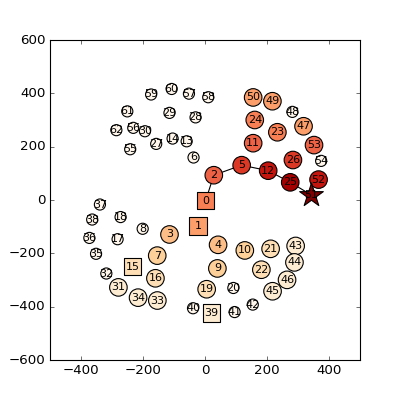

In [24]:
from plot_utils import plot_snapshot
from utils import extract_edges

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax,
              edges=extract_edges(bfs_tree))

In [25]:
original_tree, gc, mst_tree = steiner_tree_mst(g, source, 
                                               infection_times, source, 
                                               list(obs_nodes), return_closure=True, debug=True)

<IPython.core.display.Javascript object>


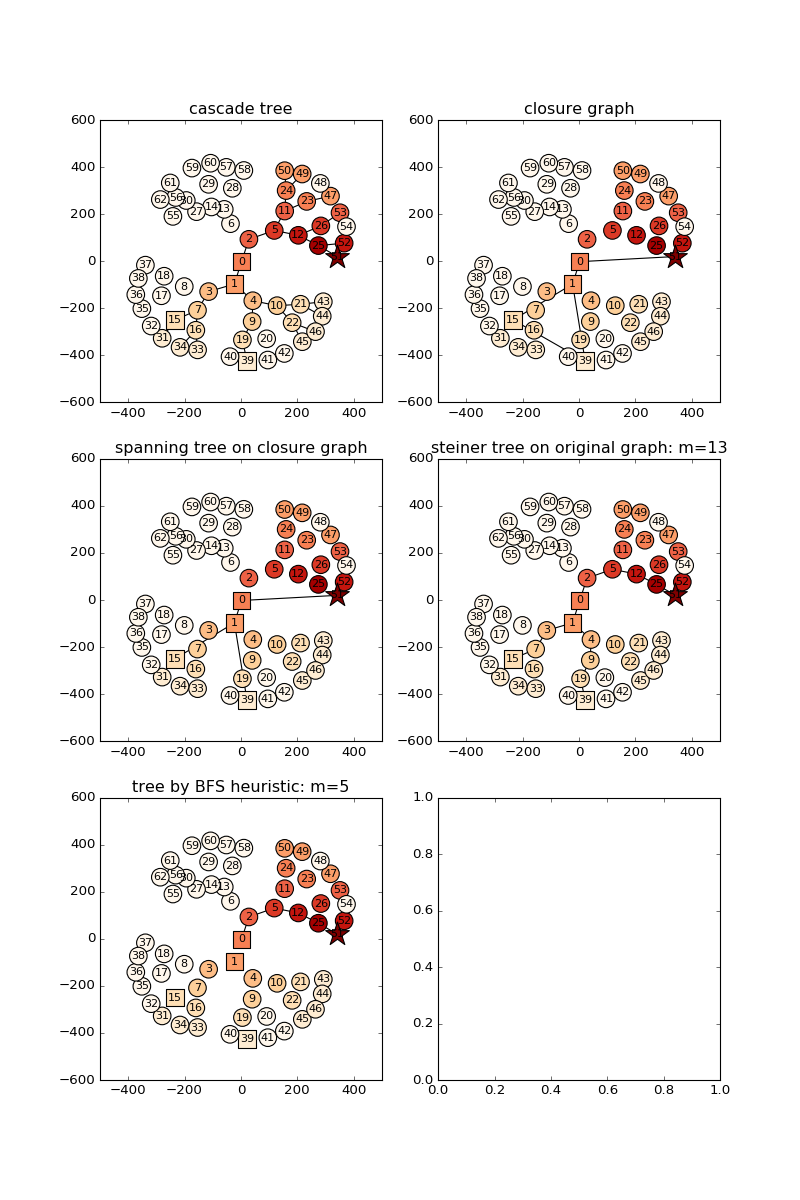

In [26]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 0],
              edges=extract_edges(true_tree))
ax[0, 0].set_title('cascade tree')
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 1],
              edges=extract_edges(gc))
ax[0, 1].set_title('closure graph')
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[1, 0],
              edges=extract_edges(mst_tree))
ax[1, 0].set_title('spanning tree on closure graph')
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[1, 1],
              edges=extract_edges(original_tree))
ax[1, 1].set_title('steiner tree on original graph: m={}'.format(original_tree.num_edges()))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[2, 0],
              edges=extract_edges(bfs_tree))
ax[2, 0].set_title('tree by BFS heuristic: m={}'.format(bfs_tree.num_edges()))

In [28]:
%%timeit -r1 -n1
from steiner_tree_order import tree_sizes_by_roots
from utils import get_rank_index
sizes = tree_sizes_by_roots(g, obs_nodes, infection_times, source, method='mst')
get_rank_index(sizes, source)

1 loop, best of 1: 1.09 s per loop
